# Deep Learning with *Dobble*

**Purpose**: A deep learning model that can play the card game *Dobble* (also known as *Spot it!*)

**Context**: Graded hands-on project as part of the *Deep Learning* Seminar at [Justus Liebig University Giessen](https://www.uni-giessen.de)

**Authors**: 2023 Marvin Theiss, Nina Winkelmann

**License**: [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.html)

<br>

## Contents
- [Importing packages](#packages)
- [Part 1: The card game *Dobble*](#dobble-game)
    * [1.1 Finite projective planes](#finite-projective-planes)
        + [1.1.1 On the existence of finite projective planes](#existence-of-finite-projective-planes)
- [Part 2: Creating a custom *Dobble* deck](#dobble-deck)
    * [2.1 Prime powers](#dobble-deck-prime-powers)
    * [2.2 Incidence matrices for finite projective planes](#dobble-deck-incidence-matrices)
    * [2.3 Coordinates and radii to place emojis](#dobble-deck-coordinates-and-radii)
    * [2.4 Creating empty *Dobble* cards](#dobble-deck-empty-cards)
        + [2.4.1 Visualizing circle packings](#dobble-deck-visualize-packings)
    * [2.5 Loading emojis from directory](#dobble-deck-load-emoji)
    * [2.6 Placing emojis on cards](#dobble-deck-place-emoji)
    * [2.7 Creating a single *Dobble* card](#dobble-deck-single-card)
    * [2.8 Reading in names of all emojis of a given set](#dobble-deck-read-emoji-names)
    * [2.9 Creating a full *Dobble* deck](#dobble-deck-full-decks)
    * [2.10 All possible combinations of cards in a *Dobble* deck](#dobble-deck-combinations)
    * [2.11 All possible arrangements of pairs of cards](#dobble-deck-possible-arrangements)
    * [2.12 Combining pairs of cards into single images](#dobble-deck-combining-images)
    * [2.13 Putting it all together](#dobble-deck-final-step)
- [Part 3: A deep neural network to play *Dobble*](#neural-network)
    * [3.1 *DobbleDataset*](#neural-network-dataset)
        + [3.1.1 Transforms](#neural-network-training-transforms)
        + [3.1.2 Training, validation, and testing sets](#neural-network-training-validation-testing)
        + [3.1.3 DataLoaders](#neural-network-dataloaders)
    * [3.2 *DobbleNet*](#neural-network-dobble-net)
    * [3.3 Training & testing routines](#neural-network-training-testing-routines)
        + [3.3.1 Loss function](#neural-network-loss)
        + [3.3.2 Optimizer](#neural-network-optimizer)
        + [3.3.3 Computing accuracy](#neural-network-accuracy)
        + [3.3.4 Training the model](#neural-network-training)
    * [3.4 Overfitting a single batch](#neural-network-overfitting-single-batch)
    * [3.5 Training *DobbleNet*](#neural-network-training-dobblenet)

<a id='packages'></a>

## Importing packages
Before we start, we import all the packages that we'll be using later on.

In [1]:
import os
import random
import csv
from math import log2
from itertools import combinations, permutations
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torchvision

<a id='dobble-game'></a>

## Part 1: The card game *Dobble*
[*Dobble*](https://www.dobblegame.com/en/homepage/) is a **popular card game** that challenges players to spot matching symbols between pairs of cards. It was created by *Denis Blanchot* and *Jacques Cottereau* and has gained significant popularity due to its simple yet engaging gameplay.

<br>
<img src="https://www.dobblegame.com/wp-content/uploads/sites/2/2020/12/dobble_eclate_pageaccueil-2.png" style="margin:auto"/>
<br>
<p style="text-align: center">
    <i>Copyright 2023 by Dobble. All rights reserved.</i>
</p>
<br>

At first glance, a deck of Dobble cards may seem like a random collection of symbols, but there is an **underlying mathematical structure** that governs the game. Each card in the deck features multiple symbols, and the goal is to find the one symbol that matches with another card in the deck. The mathematical concept that *Dobble* is based on is known as a **finite projective plane**. In a finite projective plane, there are a finite number of points and lines, and certain properties hold true (we will expand on this later on). In the case of *Dobble*, the cards represent lines in the projective plane, while the symbols on the cards represent points.

The key idea of *Dobble* is that every pair of cards in the deck will have **exactly one** symbol in common. This property is what makes Dobble intriguing and challenging. The number of symbols on each card determines the order of the finite projective plane, with the order being one less than the number of symbols (again, we'll get back to this later).

By utilizing the principles of finite projective planes, one can systematically construct a deck of *Dobble* cards such that every card has a unique set of symbols, and any two cards will always share exactly one symbol. There are several well-written articles covering the mathematical structure underlying *Dobble*. Here is a non-exhaustive list:
- [The maths behind Dobble](https://mickydore.medium.com/dobble-theory-and-implementation-ff21ddbb5318) by *Micky Dore*
- [Finite Projective Planes and the Math of Spot It!](https://puzzlewocky.com/games/the-math-of-spot-it/) on *puzzlewocky.com*
- [The Mathematics of Toys and Games](https://www.petercollingridge.co.uk/blog/mathematics-toys-and-games/dobble/) by *Peter Collingridge*
- [Dobble](https://en.wikipedia.org/wiki/Dobble) on *Wikipedia*

Also, a diploma thesis (in German) focusing on the math behind *Dobble* can be found here:
- [Ein Einblick in die Mathematik hinter dem Kartenspiel Dobble](https://unipub.uni-graz.at/obvugrhs/download/pdf/6499156?originalFilename=true) by *Christian Kathrein*

<a id='finite-projective-planes'></a>

### 1.1 Finite projective planes
We have claimed that a deck of *Dobble* cards is essentially a finite projective plane where cards in the deck correspond to lines in the projective plane and the symbols on each card correspond to the points on a line. But, what is a *finite projective plane* to beign with? Let's start with a concept that all of us will be very familiar with: the **Euclidean plane**.


<font color = red>**TO-DO:**</font> Expand this part!

Some **key aspects** of projective planes to keep in mind:
- Each projective plane (finite or infinite) has as many lines as it has points.
- For every *finite* projective plane, there exists an integer $n \geq 2$ such that ...
    * the number of points and lines is given by $n^2 + n + 1$,
    * there are $n + 1$ points on each line,
    * there are $n + 1$ lines passing through each point.
- This number $n$ is called the **order** of the projective plane.

<a id='existence-of-finite-projective-planes'></a>

#### 1.1.1 On the existence of finite projective planes

It is known that there exists a projective plane of order $n = p^k$ for every *prime power* $p^k$. What's perhaps even more intriguing is the fact that, as of today, **all** known finite projective planes are of order $p^k$ for some prime number $p$.

<a id='dobble-deck'></a>

## Part 2: Creating a custom *Dobble* deck
Emojis are taken from [OpenMoji](https://openmoji.org) and are free to use under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, which is compatible with the [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html).

<a id='dobble-deck-prime-powers'></a>

### 2.1 Prime powers
We want to generate incidence matrices for finite projective planes. These finite projective planes will be constructed using the **vector space construction with finite fields**. This construction only works for projective planes of order $n = p^k$ with $p$ being prime. Hence, we need to be able to check whether a given integer $n$ is a prime power or not.

In [2]:
def is_prime(num):
    """
    Check if a number is prime.

    Params:
        num (float): The number to be checked.

    Returns:
        bool: True if the number is prime, False otherwise.
    """
    is_integer = isinstance(num, int) or (isinstance(num, float) and num.is_integer())
    
    if not is_integer or num <= 1:
        return False

    # Check for non-trivial factors
    for i in range(2, int(num**0.5) + 1):
        if num % i == 0:
            return False
    return True


def is_prime_power(num):
    """
    Check if a number is a prime power.

    Params:
        num (float): The number to be checked.

    Returns:
        bool: True if the number is a prime power, False otherwise.
    """
    is_integer = isinstance(num, int) or (isinstance(num, float) and num.is_integer())
    
    if not is_integer or num <= 1:
        return False

    # Compute the i-th root of num and check if it's prime
    for i in range(1, int(log2(num)) + 1):
        root = num**(1 / i)
        if root.is_integer() and is_prime(root):
            return True
    return False


Let's check out all prime powers up to $n=50$.

In [3]:
first_prime_powers = []
for i in range(50):
    if is_prime_power(i + 1):
        first_prime_powers.append(i + 1)
print(first_prime_powers)

[2, 3, 4, 5, 7, 8, 9, 11, 13, 16, 17, 19, 23, 25, 27, 29, 31, 32, 37, 41, 43, 47, 49]


<a id='dobble-deck-incidence-matrices'></a>

### 2.2 Incidence matrices for finite projective planes

The function `compute_incidence_matrix` is based on the algorithm presented in the article [The Dobble Algorithm](https://mickydore.medium.com/the-dobble-algorithm-b9c9018afc52) by *Micky Dore*.

In [4]:
def compute_incidence_matrix(order):
    """
    Compute the incidence matrix corresponding to a finite projective plane of the specified order.

    Params:
        order (int): The order of the finite projective plane.

    Returns:
        np.ndarray: The computed incidence matrix.  The rows correspond to lines and the columns correspond to points.

    Raises:
        ValueError: If the argument 'order' is not a prime power.

    Example:
        >>> compute_incidence_matrix(2)
        array([[ True,  True,  True, False, False, False, False],
               [ True, False, False,  True,  True, False, False],
               [ True, False, False, False, False,  True,  True],
               [False,  True, False,  True, False,  True, False],
               [False,  True, False, False,  True, False,  True],
               [False, False,  True,  True, False, False,  True],
               [False, False,  True, False,  True,  True, False]])
    """
    if not is_prime_power(order):
        raise ValueError("The 'order' argument must be a prime power.")
    
    # Number of points/lines of a finite projective plane of order n is given by n^2 + n + 1
    size = order**2 + order + 1
    
    # Preallocate incidence matrix, where rows correspond to lines and columns correspond to points
    incidence_matrix = np.zeros((size, size), dtype=bool)

    # Determine which points are on the first line
    which_line = 0
    which_pts = list(range(order + 1))
    incidence_matrix[which_line, which_pts] = True

    # Determine which points are on the next n lines
    for line in range(order):
        which_line += 1
        # The first n + 1 lines will all share point '0'
        which_pts = [0]
        start = (line + 1) * order + 1
        end = start + order
        which_pts.extend(list(range(start, end)))
        incidence_matrix[which_line, which_pts] = True
    
    # Determine which points are on the final n^2 lines
    for block in range(order):
        for line in range(order):
            which_line += 1
            which_pts = [block + 1]
            for pt in range(order):
                which_pts.append(order * (pt + 1) + ((block * pt + line) % order) + 1)
            incidence_matrix[which_line, which_pts] = True
    
    return incidence_matrix


<a id='dobble-deck-coordinates-and-radii'></a>

### 2.3 Coordinates and radii to place emojis
We want to place a (varying) number of emojis on our *Dobble* cards. When doing so, we want to utilize the available space on each card as much as possible wihtout having the emojis overlap. The emojis we'll be using are square images of equal size (618 x 618 pixels) with transparent background (PNG files). Due to the [styleguide](https://openmoji.org/styleguide/#styleguide) that's used by [OpenMoji](https://openmoji.org), most emojis do not extend into the corners of the image. Thus, to utilize the available space on each *Dobble* card as much as possible such that no overlapping occurs, we can employ results from the branch of mathematics known as [circle packing](https://en.wikipedia.org/wiki/Circle_packing).

On his website [packomania.com](http://www.packomania.com), Prof. Dr.-Ing. [Eckehard Specht](https://www.ltv.ovgu.de/Mitarbeiter/Lehrstuhlinhaber/Prof_+Eckehard+Specht-p-210.html) provides an incredible amount of data on circle packings. From this website, we have already downloaded the data we need and placed it into the subdirectory `coords` of our current working directory. Inside this directory, there are the following five subdirectories:

- `cci`
- `ccib`
- `ccic`
- `ccir`
- `ccis`

The names of these subdirectories are obtained from the names that Prof. Dr.-Ing. Eckehard Specht uses for the different circle packings that he provides on his [website](http://www.packomania.com).

All of the subdirectories qualitatively contain the same data:

- Multiple text files containing the **coordinates of all the circles** in the circle packing. The file names consist of the name of the directory followed by the number of circles in the circle packing (e.g., *cci4.txt* or *ccir32.txt*). All text files consist of three columns: the first column stores a simple counter, the second column contains the $x$-coordinate, and the third column contains the $y$-coordinate of the center of each circle.
- A single text file `radius.txt` that stores the **radius of the largest circle** of each circle packing. This file contains two columns: the first one specifies the number of circles in the circle packing and the second one provides the radius of the largest circle in the packing. The radii of all the other circles can be computed based on this radius. We will get back to this later.

Generally, this data is available for circle packings where the number of circles are integers up to $n = 50$ that can be expressed as $p^k + 1$ with $p$ being prime (i.e., integers that immediately follow a prime power).

<font color=red>**Important:**</font> For $n = 3, 4$ this data is **only** available for circle packings of type `cci`.

Next, let's define a dictionary `packing_types_dict` that stores all the different types of packings that are available. The value associated with each key is a tuple consisting of ...
- a function that can be used to compute the remaining radii of a circle packing of that type
- a string that indicates whether this function is monotonically increasing or decreasing

In [5]:
packing_types_dict = {
    "cci": (lambda n: 1, "increasing"),
    "ccir": (lambda n: n ** (1 / 2), "increasing"),
    "ccis": (lambda n: n ** (-1 / 2), "decreasing"),
    "ccib": (lambda n: n ** (-1 / 5), "decreasing"),
    "ccic": (lambda n: n ** (-2 / 3), "decreasing")
}

Next, we provide two functions that read the coordinates and the radius of the largest circle in a circle packing from the corresponding text file.

In [6]:
coords_dir_path = os.path.join('..', 'data', 'external', 'coords')

def read_coordinates_from_file(num_circles, packing_type, packing_types_dict, coords_dir_path):
    """Read the coordinates of the specified circle packing from a text file.

    Params:
        num_circles (int): The number of circles in the circle packing.
        packing_type (str): The type of circle packing.  Must be one of the keys in the 'packing_types' dictionary.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.
        coords_dir_path (str): The path to the directory containing the coordinates files.

    Returns:
        list[list[float]]: A list of coordinates of all the circles in the circle packing.

    Raises:
        FileNotFoundError: If the text file for the specified packing type and number of circles is not found.
        ValueError: If the 'packing_type' is not one of the supported packing types.
    """
    # Validate the packing_type argument
    if packing_type not in packing_types_dict:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")

    filename = os.path.join(coords_dir_path, packing_type, packing_type + str(num_circles) + '.txt')

    try:
        with open(filename, 'r') as file:
            # Read values line by line, split into separate columns and get rid of first column of text file
            coordinates = [line.strip().split()[1:] for line in file.readlines()]
            coordinates = [[float(coord) for coord in coord_list] for coord_list in coordinates]
        return coordinates
    except FileNotFoundError:
        raise FileNotFoundError(f"Coordinates file for '{packing_type}' packing with {num_circles} circles not found.")


def read_radius_from_file(num_circles, packing_type, packing_types_dict, coords_dir_path):
    """Read the radius of the largest circle of the specified circle packing from a text file.

    Params:
        num_circles (int): The number of circles in the circle packing.
        packing_type (str): The type of circle packing.  Must be one of the keys in the 'packing_types' dictionary.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.
        coords_dir_path (str): The path to the directory containing the coordinates files.

    Returns:
        float: The radius of the largest circle of the circle packing.

    Raises:
        FileNotFoundError: If the 'radius.txt' file for the specified packing type is not found.
        ValueError: If the 'packing_type' is not one of the supported packing types.
        ValueError: If no radius is found for the specified packing type and number of circles.
    """
    # Validate the packing_type argument
    if packing_type not in packing_types_dict:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")
    
    filename = os.path.join(coords_dir_path, packing_type, 'radius.txt')

    try:
        with open(filename, 'r') as file:
            for line in file:
                values = line.strip().split()
                if len(values) == 2 and int(values[0]) == num_circles:
                    return float(values[1])

        raise ValueError(f"No radius found for packing type '{packing_type}' with {num_circles} circles.")
    except FileNotFoundError:
        raise FileNotFoundError(f"Radius file for '{packing_type}' packing not found.")


The function `read_radius_from_file` **only** provides the radius of the **largest circle** of the circle packing. Based on this largest radius, the number of circles in the circle packing, and the type of circle packing, we want to compute the radii of all of the remaining cirlces. To do so, we write another function, which we call `compute_radii`.

<font color=red>**TO-DO:**</font> Expand on how this is done (i.e., what's the logic behind the computations below)!

In [7]:
def compute_radii(largest_radius, num_circles, packing_type, packing_types_dict):
    """Compute the radii of circles in a circle packing.

    Params:
        largest_radius (float): The radius of the largest circle in the circle packing.
        num_circles (int): The total number of circles in the circle packing.
        packing_type (str): The type of circle packing.  Must be one of the keys in the 'packing_types' dictionary.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.

    Returns:
        list[float]: The computed radii of the circles in the circle packing.

    Raises:
        ValueError: If the 'packing_type' is not one of the supported packing types.
    """
    # Validate the packing_type argument
    if packing_type not in packing_types_dict:
        raise ValueError(f"Invalid packing type: '{packing_type}' is not supported.")

    fctn, monotonicity = packing_types_dict[packing_type]
    fctn_vals = [fctn(n + 1) for n in range(num_circles)]

    # If the function 'fctn' is decreasing, we reverse the order of 'fctn_vals' so that the values are
    # listed in increasing order
    if monotonicity == "decreasing":
        fctn_vals.reverse()
    
    ratio = largest_radius / fctn_vals[-1]
    radii = [fctn_vals[n] * ratio for n in range(num_circles)]

    return radii


Using the functions `read_coordinates_from_file`, `read_radius_from_file`, and `compute_radii`, we can obtain NumPy arrays that contain the coordinates of the centers of all of the circles in the specified circle packing as well as their radii. However, these values (i.e., coordinates **and** radii) are all *relative*. The coordinates are relative to a square whose $x$- and $y$-values range from $-1$ to $1$ and the radii of the circles are relative to a circle inscribed in this particular square (e.g., a radius of $0.5$ means that the respective circle has half of the radius of the aforementioned inscribed circle.)

Given the `image_size`of a square image (in our case, this will be an empty *Dobble* card), we now convert these relative values to absolute (pixel) values.

In [8]:
def convert_coords_to_pixels(rel_coords, image_size):
    """
    Convert relative coordinates to pixel values based on the size of a square image.

    The function takes relative coordinates in the range of [-1, 1] and converts them to pixel values
    based on the size of a square image.  The relative coordinates are assumed to be in a normalized form,
    where the origin (0, 0) corresponds to the center of the image and the values (-1, -1) and (1, 1)
    correspond to the lower left and upper right corner of the image, respectively.

    Params:
        rel_coords (np.ndarray or tuple): Relative coordinates in the range of [-1, 1] in the form (x, y).
        image_size (int): Size of the square image.

    Returns:
        tuple[int, int]: Pixel values corresponding to the relative coordinates.

    Raises:
        ValueError: If the relative coordinates are outside the range of [-1, 1].

    Examples:
        >>> convert_coords_to_pixels((-0.5, 0.75), 512)
        (128, 448)

        >>> convert_coords_to_pixels((0.25, 0.5), 256)
        (160, 192)
    """
    # Convert rel_coords to NumPy array if necessary
    if not isinstance(rel_coords, np.ndarray):
        rel_coords = np.array(rel_coords)

    # Check if the relative coordinates are within the range of [-1, 1]
    if np.any((rel_coords < -1) | (rel_coords > 1)):
        raise ValueError("Relative coordinates must be in the range of [-1, 1].")
    
    # Shift coordinates from [-1, 1] to [0, 1]
    rel_coords = rel_coords / 2 + 0.5

    # Scale coordinates from [0, 1] to [0, card_size] and convert to integer values
    coords = np.floor(rel_coords * image_size).astype('int')

    return tuple(coords)


def convert_radius_to_pixels(rel_radius, bg_size):
    """
    Convert a relative radius from 0 to 1 to image size in pixels based on the size of a square image (background).

    Params:
        rel_radius (float): Relative radius in the range of [0, 1].
        bg_size (int): Size of the square image in pixels that serves as background.

    Returns:
        int: Size of the square image in pixels to be placed on the background.

    Raises:
        ValueError: If the relative radius is outside the valid range of [0, 1].

    Example:
        >>> convert_radius_to_pixels(0.5, 512)
        256
    """
    if rel_radius < 0 or rel_radius > 1:
        raise ValueError("Relative radius must be in the range of [0, 1].")

    image_size = int(rel_radius * bg_size)
    
    return image_size


<a id='dobble-deck-empty-cards'></a>

### 2.4 Creating empty *Dobble* cards
The starting point for each *Dobble* card will be a square image consisting of nothing but a white circle against a transparent background.

In [9]:
def create_empty_card(image_size, return_pil=True):
    """
    Create a square image of a white circle against a transparent background.

    Params:
        image_size (int): The size of the square image in pixels.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        PIL.Image.Image or np.ndarray: The generated image of a white circle against a transparent background.
    """
    # Create a new transparent image with RGBA mode
    image = Image.new("RGBA", (image_size, image_size), (0, 0, 0, 0))
    
    # Create a new draw object
    draw = ImageDraw.Draw(image)
    
    # Calculate the coordinates of the circle to maximize its size within the square image
    circle_x = image_size // 2
    circle_y = image_size // 2
    radius = image_size // 2
    
    # Draw a white circle on the image
    draw.ellipse((circle_x - radius, circle_y - radius,
                  circle_x + radius, circle_y + radius),
                 fill=(255, 255, 255, 255))
    
    if return_pil:
        return image
    else:
        # Convert the image to a numpy array
        image_array = np.array(image)
        return image_array


<a id='dobble-deck-visualize-packings'></a>

#### 2.4.1 Visualizing circle packings
Before we move on, we want to visualize the different circle packings. This will give us a good idea of how much the different types of circle packings specified in the `packing_types_dict` dictionary differ from each other. First, we write a simple function that draws a circle on any image at a given position and size.

In [10]:
def draw_circle(image, center, diameter, filled=False, fill_color=0, return_pil=True):
    """
    Draw a circle on the given PIL image.

    Params:
        image (PIL.Image.Image): The image on which to draw the circle.
        center (tuple): The center coordinates of the circle in the form (x, y).
        diameter (int): The diameter of the circle.
        filled (bool): Whether the circle should be filled (True) or just have an outline (False).  Defaults to False.
        fill_color (tuple): The fill color of the circle in RGB format. Used when 'filled' is True.  Defaults to 0.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        PIL.Image.Image or np.ndarray: The modified image with the circle drawn onto it.
    """
    # Create a new draw object
    draw = ImageDraw.Draw(image)
    
    # Get x- and y-coordinates of the circle and compute radius
    circle_x, circle_y = center
    radius = diameter // 2
    
    if filled:
        # Draw a filled circle
        draw.ellipse((circle_x - radius, circle_y - radius,
                      circle_x + radius, circle_y + radius),
                     fill=fill_color)
    else:
        # Draw the outline of the circle
        draw.ellipse((circle_x - radius, circle_y - radius,
                      circle_x + radius, circle_y + radius),
                     outline=(0, 0, 0))

    if return_pil:
        return image
    else:
        # Convert the image to a NumPy array
        image_array = np.array(image)
        return image_array


Next, we use the `draw_circle` function to build another function called `visualize_packing` that iteratively draws all of the circles of a given circle packing (i.e., type of packing and number of circles) on an empty *Dobble* card.

In [11]:
def visualize_packing(num_circles, packing_type, packing_types_dict, card_size, coords_dir_path,
                      filled=False, fill_color=0, return_pil=True):
    """
    Visualize a circle packing on an empty Dobble card based on the given parameters (i.e., type of packing and
        number of circles).

    Params:
        num_circles (int): The number of circles in the circle packing.
        packing_type (str): The type of circle packing.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.
        card_size (int): The size of each card in pixels.
        coords_dir_path (str): The path to the directory containing the coordinates files.
        filled (bool): Whether the circles should be filled (True) or just have outlines (False).  Defaults to False.
        fill_color (tuple): The fill color of the circles in RGB format. Used when 'filled' is True.  Defaults to 0.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        PIL.Image.Image or np.ndarray: The card image with the packing visualized.
    """
    # Create empty card as PIL image
    packing = create_empty_card(card_size)

    # Read relative coordinates from file
    relative_coordinates = read_coordinates_from_file(num_circles, packing_type, packing_types_dict, coords_dir_path)

    # Read largest radius from file and compute remaining radii
    largest_radius = read_radius_from_file(num_circles, packing_type, packing_types_dict, coords_dir_path)
    relative_radii = compute_radii(largest_radius, num_circles, packing_type, packing_types_dict)

    # Draw circles on card
    for circle in range(num_circles):
        center = convert_coords_to_pixels(relative_coordinates[circle], card_size)
        diameter = convert_radius_to_pixels(relative_radii[circle], card_size)
        packing = draw_circle(packing, center, diameter, filled, fill_color)

    if return_pil:
        return packing
    else:
        # Convert the image to a NumPy array
        packing_array = np.array(packing)
        return packing_array


Finally, we actually plot a few select circle packings (i.e., all available packing types with $n = 5, 6, 8, 9$ circles).

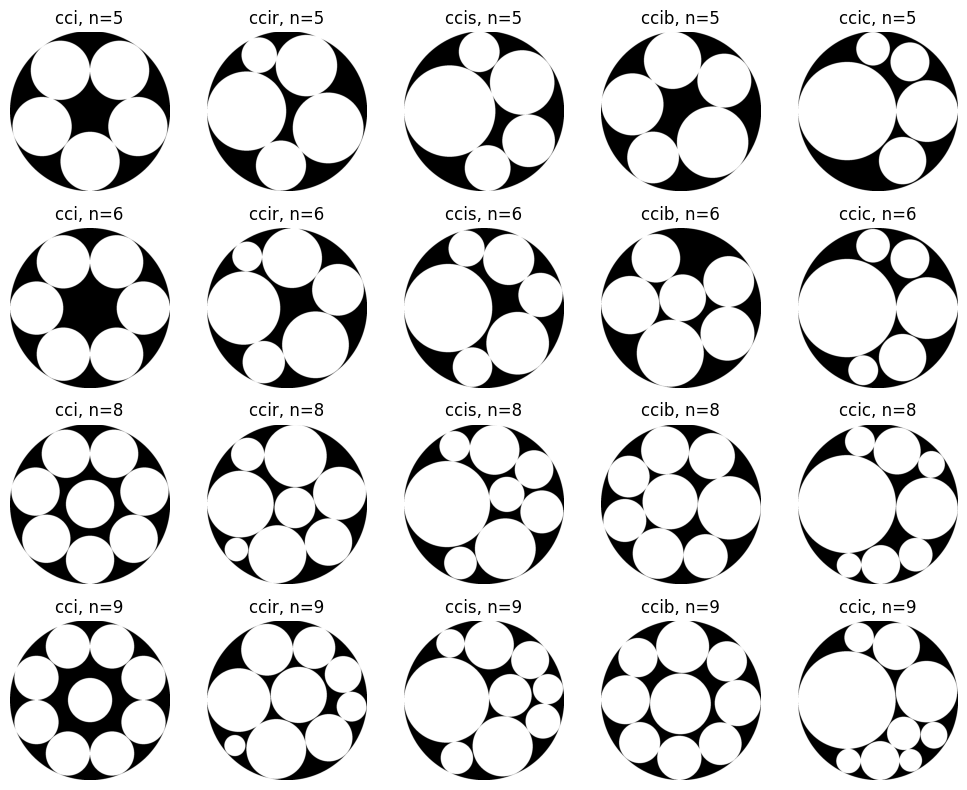

In [12]:
num_circles_list = [5, 6, 8, 9]
num_rows = len(num_circles_list)
num_cols = len(packing_types_dict)
card_size = 1024

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for row, num_circles in enumerate(num_circles_list):
    for col, packing_type in enumerate(packing_types_dict.keys()):
        image_array = visualize_packing(num_circles, packing_type, packing_types_dict, card_size, coords_dir_path,
                                        filled=True, return_pil=False)

        # Make the image fully opaque (i.e., turn transparent background black)
        image_array[..., 3] = 255

        # Separate color channels and alpha channel
        color_channels = image_array[..., :3]
        alpha_channel = image_array[..., 3]

        # Invert color channels
        inverted_color_channels = 255 - color_channels

        # Combine inverted color channels with alpha channel
        image_array = np.concatenate((inverted_color_channels, alpha_channel[..., np.newaxis]), axis=2)
        
        axes[row, col].imshow(image_array)
        title = f"{packing_type}, n={num_circles}"
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


<a id='dobble-deck-load-emoji'></a>

### 2.5 Loading emojis from directory
To create our *Dobble* cards, we first need to load the emojis from the `emojis` directory. As mentioned before, the emojis used in this project are taken from [OpenMoji](https://openmoji.org) and are free to use under the [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/) license, which is compatible with the [GNU General Public License v3](https://www.gnu.org/licenses/gpl-3.0.en.html).

In [13]:
emojis_dir_path = os.path.join('..', 'data', 'external', 'emojis')

def load_emoji(emoji_set, emoji_name, emojis_dir_path, outline_only=False):
    """
    Load an emoji from the specified set of emojis.

    Params:
        emoji_set (str): The name of the set of emojis (e.g., 'classic-dobble').
        emoji_name (str): The name of the emoji to load.
        emojis_dir_path (str): The path to the directory containing the emoji images.
        outline_only (bool): Whether to load the outline-only version of the emoji.  Defaults to False.

    Returns:
        PIL.Image.Image: The loaded emoji image in RGBA mode.

    Raises:
        ValueError: If the specified emoji file is not found or does not have a valid PNG extension.
    """
    # Create the filepath pointing to the emoji that we want to load
    if outline_only:
        which_type = 'outline'
    else:
        which_type = 'color'

    filepath = os.path.join(emojis_dir_path, emoji_set, which_type, emoji_name + '.png')

    # Check if the file exists and if it has the correct extension
    if os.path.isfile(filepath) and filepath.lower().endswith('.png'):
        emoji_image = Image.open(filepath)

        # Convert the image to RGBA mode if it's not already
        if emoji_image.mode != 'RGBA':
            emoji_image = emoji_image.convert('RGBA')

        return emoji_image
    else:
        raise ValueError(f"Failed to load emoji: {filepath} is not a valid PNG file.")


<a id='dobble-deck-place-emoji'></a>

### 2.6 Placing emojis on cards
The `load_emoji` function returns an emoji as a PIL image in RGBA mode. Once we have such an image loaded into memory, we want to place it on another image (i.e., a *Dobble* card). The next function does just that.

In [14]:
def place_emoji(image, emoji_image, emoji_size, center, rotation_angle=None, return_pil=True):
    """
    Place an emoji on the given image at the specified coordinates with the specified size.

    Params:
        image (PIL.Image.Image): The original image as a PIL Image.
        emoji_image (PIL.Image.Image): The emoji as a PIL Image.
        emoji_size (int): The desired size of the emoji in pixels when placed on the image.
        center (tuple): The center coordinates of the emoji in the form (x, y).
        rotation_angle (float): The rotation angle in degrees. Defaults to None.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False). Defaults to True.

    Returns:
        PIL.Image.Image or np.ndarray:: The modified image with the emoji placed on it.

    Raises:
        ValueError: If the rotation_angle is provided but is outside the valid range of [0, 360).
    """
    x_center, y_center = center
    
    # Calculate the top-left coordinates of the emoji based on the center coordinates and size
    x_left = x_center - emoji_size // 2
    y_top = y_center - emoji_size // 2

    # Resize the emoji to the specified size
    emoji_image = emoji_image.resize((emoji_size, emoji_size))

    # Check if a rotation angle was specified and validate it
    if rotation_angle is not None:
        if rotation_angle < 0 or rotation_angle >= 360:
            raise ValueError("Invalid rotation angle: must be in the range [0, 360).")
        
        # Rotate the image if the rotation angle is valid
        emoji_image = emoji_image.rotate(rotation_angle)

    # Paste the emoji onto the original image at the specified coordinates
    image.paste(emoji_image, (x_left, y_top), mask=emoji_image)

    if return_pil:
        return image
    else:
        # Convert the image to a NumPy array
        image_array = np.array(image)
        return image_array


<a id='dobble-deck-single-card'></a>

### 2.7 Creating a single *Dobble* card

In [15]:
def create_dobble_card(card_size, packing_type, packing_types_dict, coords_dir_path,
                       emoji_set, emoji_list, emojis_dir_path, outline_only=False, return_pil=True):
    """
    Create a Dobble card by placing emojis according to the given parameters.

    Params:
        card_size (int): The size of the card in pixels.
        packing_type (str): The type of circle packing.  Must be one of the keys in the 'packing_types' dictionary.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.
        coords_dir_path (str): The path to the directory containing the coordinates files.
        emoji_set (str): The name of the set of emojis.
        emoji_list (list): The list of names of the emojis to be placed on the card.
        emojis_dir_path (str): The path to the directory containing the emoji images.
        outline_only (bool): Whether to load the outline-only version of the emoji.  Defaults to False.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        PIL.Image.Image or np.ndarray:: The generated Dobble card.
    """
    # Create empty Dobble card
    dobble_card = create_empty_card(card_size)
    num_emojis = len(emoji_list)

    # Read relative coordinates from file
    relative_coordinates = read_coordinates_from_file(num_emojis, packing_type, packing_types_dict, coords_dir_path)

    # Read largest radius from file and compute remaining radii
    largest_radius = read_radius_from_file(num_emojis, packing_type, packing_types_dict, coords_dir_path)
    relative_radii = compute_radii(largest_radius, num_emojis, packing_type, packing_types_dict)

    # Place emojis on card
    for count, emoji_name in enumerate(emoji_list):
        emoji_image = load_emoji(emoji_set, emoji_name, emojis_dir_path, outline_only)
        emoji_size = convert_radius_to_pixels(relative_radii[count], card_size)
        center = convert_coords_to_pixels(relative_coordinates[count], card_size)
        rotation_angle = random.randint(0, 359)
        dobble_card = place_emoji(dobble_card, emoji_image, emoji_size, center, rotation_angle)

    # Randomly rotate the image
    # NOTE: Since the part of the image that we care about is the inscribed circle (i.e., Dobble card),
    # we can leave the 'expand' parameter of the Image.rotate method set to its default value of False!
    rotation_angle = random.randint(0, 359)
    dobble_card = dobble_card.rotate(rotation_angle)

    if return_pil:
        return dobble_card
    else:
        # Convert the image to a NumPy array
        dobble_card_array = np.array(dobble_card)
        return dobble_card_array


Next, let's visualize a few *Dobble* cards!

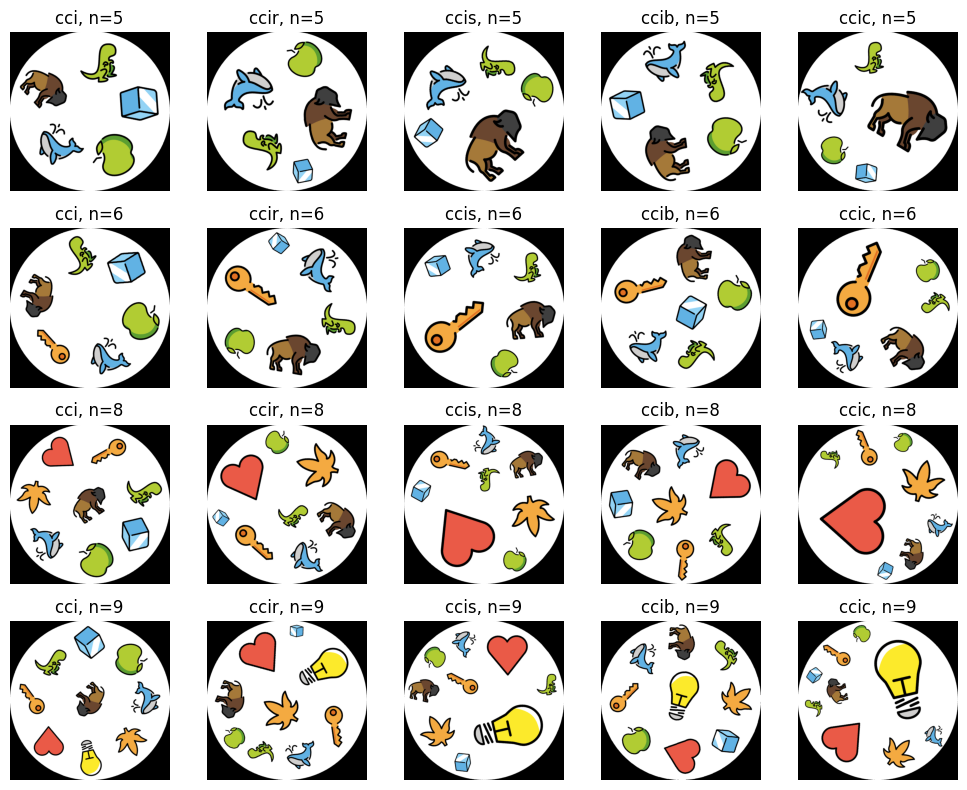

In [16]:
card_size = 1024
emoji_set = 'classic-dobble'
emoji_lists = [['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key', 'mapleleaf', 'heart'],
               ['ice', 'greenapple', 'trex', 'spoutingwhale', 'bison', 'key', 'mapleleaf', 'heart', 'lightbulb']]
num_rows = len(emoji_lists)
num_cols = len(packing_types_dict)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(packing_types_dict.keys()):
        # Create dobble card (as NumPy array)
        dobble_card_array = create_dobble_card(card_size, packing_type, packing_types_dict, coords_dir_path,
                                               emoji_set, emoji_list, emojis_dir_path, return_pil=False)
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_array[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_array)
        title = f"{packing_type}, n={len(emoji_list)}"
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


What would it look like if we were to use only the outlines of the emojis? Let's take a look!

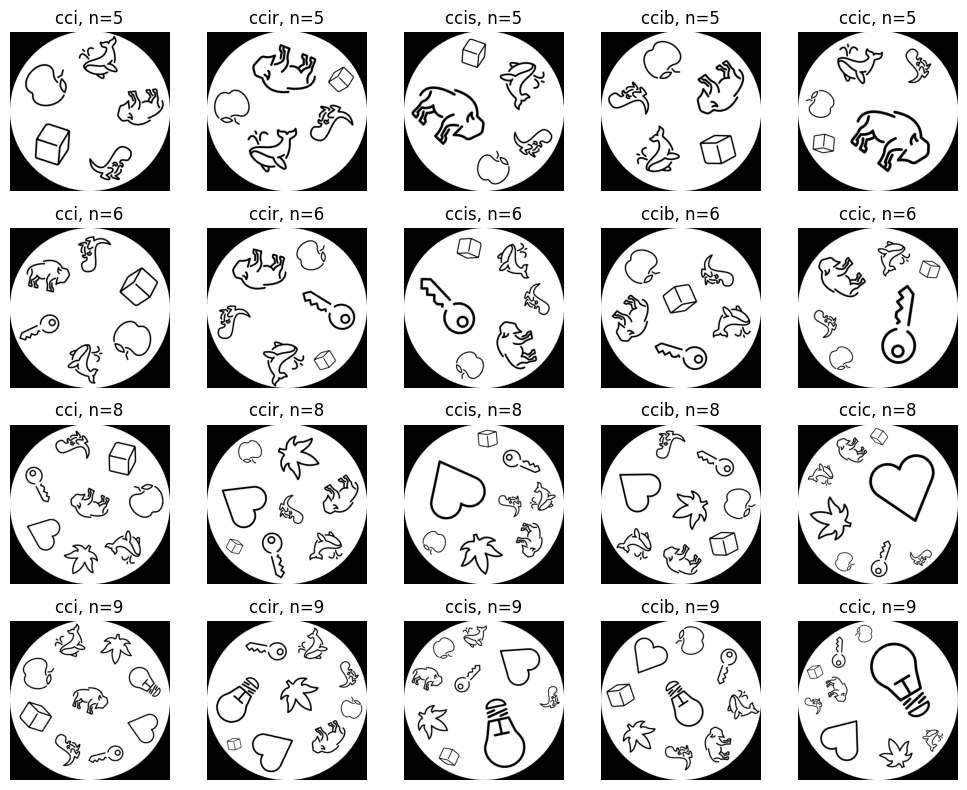

In [17]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))

for row, emoji_list in enumerate(emoji_lists):
    for col, packing_type in enumerate(packing_types_dict.keys()):
        # Create dobble card (as NumPy array)
        dobble_card_array = create_dobble_card(card_size, packing_type, packing_types_dict, coords_dir_path,
                                               emoji_set, emoji_list, emojis_dir_path, outline_only=True, return_pil=False)
        
        # Make the image fully opaque (i.e., turn transparent background black)
        dobble_card_array[..., 3] = 255
        
        axes[row, col].imshow(dobble_card_array)
        title = f"{packing_type}, n={len(emoji_list)}"
        axes[row, col].set_title(title)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


<a id='dobble-deck-read-emoji-names'></a>

### 2.8 Reading in names of all emojis of a given set
<font color = red>**TO-DO:**</font> Add explanation.

In [18]:
def get_emoji_names(emoji_set, emojis_dir_path, outline_only=False):
    """
    Retrieve the names of all emojis in the specified set of emojis.

    Params:
        emoji_set (str): The name of the emoji set to use (e.g., 'classic-dobble').
        outline_only (bool): Specifies whether to retrieve names of emojis with outline only.  Defaults to False.

    Returns:
        list[str]: A list of names of all emojis in the specified set.
    """
    if outline_only:
        dir_path = os.path.join(emojis_dir_path, emoji_set, 'outline')
    else:
        dir_path = os.path.join(emojis_dir_path, emoji_set, 'color')
    
    emoji_names = []
    for file in os.listdir(dir_path):
        if file.endswith('.png'):
            # Extract the base name without extension (i.e., without '.png')
            emoji_name = os.path.splitext(file)[0]
            emoji_names.append(emoji_name)
    emoji_names.sort()
    return emoji_names


<a id='dobble-deck-full-decks'></a>

### 2.9 Creating a full *Dobble* deck
Finally, we put everything together to create a full *Dobble* deck. Let's outline the major steps we need to take to end up with a full deck of *Dobble* cards:

These are the parameters we need to specify:
* `emoji_set` **Which set of emojis** do we want to use to create the *Dobble* deck?
* `num_emojis_per_card` **How many emojis** do we want **on each card**? Remember that this number needs to be equal to $p^k + 1$ with $p$ being prime (i.e., an integer that immediately follows a prime power).
* `deck_name` What do we want to call our newly created *Dobble* deck? This will also serve as the **name of the subdirectory** of the `dobble-decks` directory, where we will store the images.
* `outline_only` Do we want to use the **colored versions** of the emojis **or** just their **outlines**?
* `packing_type` Do we want to use one **type of circle packing** for all cards or do we want to choose the packing type randomly for each card to have greater variability between cards?

<br>

To create our *Dobble* deck, we have to perform the following steps in order:
1. Using the `deck_name` parameter, create a subdirectory to store the generated *Dobble* cards (i.e., images).
2. Compute the incidence matrix of the finite projective plane of the appropriate order (Remember: The order of the projective plane is one less than the number of symbols on each card!). We make use of the `compute_incidence_matrix` function to achieve this.
3. Read in the names of all the emojis available in the specified `emoji_set`. We use the `get_emoji_names` function to do so.
    * Make sure that there are enough emojis available in this set! The number of distinct emojis neede in total is derived from the `num_emojis_per_card`. If there aren't enough, we throw an error. If there are too many, we choose a random subset of the appropriate size.
4. Create a CSV file that will store all the necessary information we need to create our ground-truth labels later on (i.e., which is the common symbol between any pair of cards?).
5. Finally, we create our *Dobble* cards one by one. This is done as follows:
    * The `incidence_matrix` tells us which emojis need to be placed on which card (i.e., the entries in the $i$-th row determine the emojis that need to be placed on the $i$-th *Dobble* card).
    * We select the names of the corresponding emojis from the `emoji_names` list that we created earlier using the `get_emoji_names` function.
    * We shuffle this list to randomly place the emojis on the card and we create the *Dobble* card with the `create_dobble_card` function.
    * Finally, we append all the relevant information about the card that we just created to the CSV file created earlier.

In [19]:
data_dir_path = os.path.join('..', 'data', 'processed')

def create_dobble_deck_images(emoji_set, num_emojis_per_card, card_size, deck_name, packing_types_dict,
                              coords_dir_path, emojis_dir_path, data_dir_path, outline_only=False, packing_type=None):
    """
    Create a full set of Dobble cards (i.e., generate and save image files).

    Params:
        emoji_set (str): The name of the emoji set to use.
        num_emojis_per_card (int): The number of emojis to place on each card.
        card_size (int): The size of each card in pixels.
        deck_name (str): The name of the Dobble deck.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.
        coords_dir_path (str): The path to the directory containing the coordinates files.
        emojis_dir_path (str): The path to the directory containing the emoji images.
        data_dir_path (str): The path to the directory where the generated Dobble decks are to be stored.
        outline_only (bool): Whether to generate cards with outline-only emojis.  Defaults to False.
        packing_type (str): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card.  Defaults to None.

    Returns:
        tuple[str, str]: A tuple containing the filepaths to the generated CSV files that store all necessary information
            about the individual cards ('deck.csv') as well as the emoji labels ('emoji_labels.csv').
    """
    # Create a directory to store the Dobble cards
    deck_dir = os.path.join(data_dir_path, deck_name)
    # If the directory already exists (i.e., the deck has already been created), we simply return the two CSV files
    if os.path.exists(deck_dir):
        deck_csv = os.path.join(deck_dir, 'deck.csv')
        emoji_labels_csv = os.path.join(deck_dir, 'emoji_labels.csv')
        return deck_csv, emoji_labels_csv
    else:
        os.makedirs(deck_dir)
    
    # Compute order of finite projective plane as well as its incidence matrix
    order = num_emojis_per_card - 1
    incidence_matrix = compute_incidence_matrix(order)

    # The number of cards in a Dobble deck is given by n^2 + n + 1, with n + 1 = # symbols on each card
    # NOTE: Remember that there are as many distinct symbols in a deck of Dobble cards as there are cards
    num_cards = order ** 2 + order + 1

    # Read in the names of all emojis in the specified subdirectory ('emoji_set') of the 'emojis' directory
    emoji_names = get_emoji_names(emoji_set, emojis_dir_path, outline_only)

    # Check if there are enough emojis in the specified subdirectory
    num_emojis_available = len(emoji_names)
    if num_emojis_available < num_cards:
        raise ValueError("Not enough emojis in the specified set of emojis to create the Dobble deck.")
    elif num_emojis_available > num_cards:
        # If there are more emojis than we need, we randomly choose a subset of the appropriate size
        emoji_names = random.sample(emoji_names, num_cards)

    # Create CSV file to store information about the individual emojis and their corresponding labels
    emoji_labels = pd.DataFrame({'EmojiName': emoji_names, 'EmojiLabel': range(len(emoji_names))})
    emoji_labels_csv = os.path.join(deck_dir, 'emoji_labels.csv')
    emoji_labels.to_csv(emoji_labels_csv, index=False)

    # If no 'packing_type' was provided initially, choose one randomly each time from the 'packing_types_dict' dictionary
    choose_randomly = True if packing_type is None else False

    # Create CSV file to store information about the individual cards
    deck_csv = os.path.join(deck_dir, 'deck.csv')
    with open(deck_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['FilePath'] + ['PackingType'] + ['Emoji' + str(i+1) for i in range(num_emojis_per_card)])
    
    # Create Dobble cards one-by-one using the incidence matrix to decide which emojis to put on each card
    # NOTE: len(a) is equivalent to np.shape(a)[0] for N-D arrays with N>=1.
    for card in range(len(incidence_matrix)):
        # Find the emojis that are to be placed on the card
        which_emojis = np.where(incidence_matrix[card])[0]
        emoji_list = [emoji_names[idx] for idx in which_emojis]
        random.shuffle(emoji_list)
        
        # If no 'packing_type' was provided initially, choose one randomly from the 'packing_types_dict' dictionary
        if choose_randomly:
            packing_type = random.choice(list(packing_types_dict.keys()))
        
        # Create Dobble card and save in directory
        dobble_card = create_dobble_card(card_size, packing_type, packing_types_dict, coords_dir_path,
                                         emoji_set, emoji_list, emojis_dir_path, outline_only)
        filename = f"{deck_name}_{card + 1:03d}.png"
        filepath = os.path.join(deck_dir, filename)
        dobble_card.save(filepath)

        # Write card information to the CSV file
        with open(deck_csv, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([filepath] + [packing_type] + emoji_list)

    return deck_csv, emoji_labels_csv


<font color=red>**TO-DO:**</font> Add text!

In [20]:
def create_labels_dict(emoji_labels_csv):
    """
    Create a dictionary mapping emoji labels (integers starting from 0) to their corresponding names.

    Params:
        emoji_labels_csv (str): The filepath to the CSV file 'emoji_labels.csv' containing emoji labels and names.

    Returns:
        dict: A dictionary mapping emoji labels to names.
    """
    # Read the emoji labels and names from the CSV file
    emoji_labels_df = pd.read_csv(emoji_labels_csv)

    # Create the dictionary mapping emoji labels to names
    labels_dict = dict(zip(emoji_labels_df['EmojiLabel'], emoji_labels_df['EmojiName']))

    return labels_dict


<font color=red>**TO-DO:**</font> Add text!

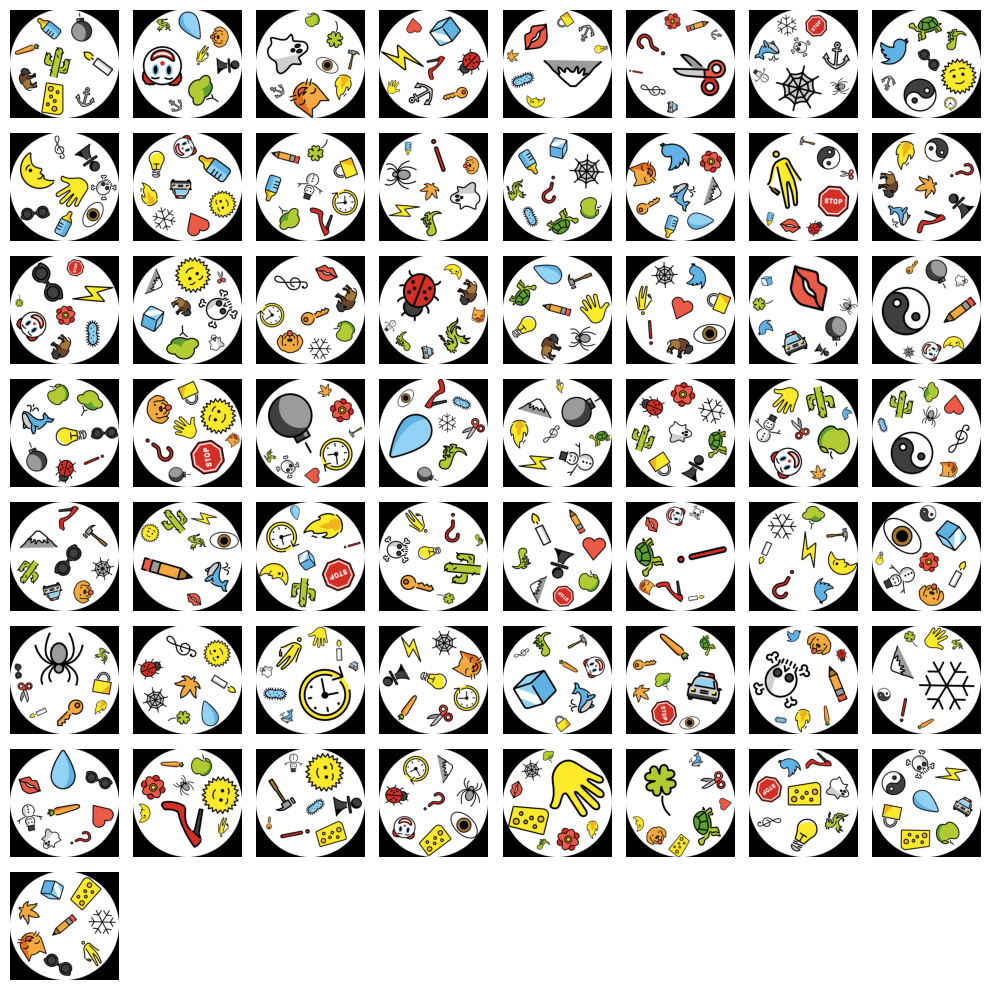

In [21]:
# Create our first full deck of Dobble cards
emoji_set = 'classic-dobble'
num_emojis_per_card = 8
card_size = 1024
deck_name = 'classic-dobble-1024-px'
deck_csv_1024, emoji_labels_csv_1024 = create_dobble_deck_images(emoji_set, num_emojis_per_card, card_size, deck_name,
                                                                 packing_types_dict, coords_dir_path, emojis_dir_path,
                                                                 data_dir_path, outline_only=False, packing_type=None)

# Extract filepaths from CSV file
image_paths = pd.read_csv(deck_csv_1024)['FilePath'].values.tolist()

# Visualize all 7^2 + 7 + 1 = 57 cards in an 8x8 layout
fig, axes = plt.subplots(8, 8, figsize=(10, 10))

for count, ax in enumerate(axes.flat):
    # Check if there are still images remaining
    if count < len(image_paths):
        image = Image.open(image_paths[count])
        image_array = np.array(image)
        
        # Make the image fully opaque (i.e., turn transparent background black)
        image_array[..., 3] = 255
        ax.imshow(image_array)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


<a id='dobble-deck-combinations'></a>

### 2.10 All possible combinations of cards in a *Dobble* deck
<font color=red>**TO-DO:**</font> Add text!

In [22]:
def create_combinations_csv(deck_csv, emoji_labels_csv):
    """
    Create a CSV file containing all possible combinations of cards in a Dobble deck generated by the 'create_dobble_deck_images' function.

    Params:
        deck_csv (str): The filepath to the CSV file 'deck.csv' generated by the 'create_dobble_deck_images' function.

    Returns:
        str: The filepath to the created CSV file 'combinations.csv'.
    """
    # Check if combinations CSV has already been created
    deck_dir = os.path.dirname(deck_csv)
    combinations_csv = os.path.join(deck_dir, 'combinations.csv')
    if os.path.exists(combinations_csv):
        return combinations_csv

    # Read the card information from the CSV file 'deck_csv'into a list of lists,
    # where inner lists correspond to rows of the CSV file
    with open(deck_csv, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        deck_info = list(reader)

    # Read the mapping information (i.e., emoji names to integers) from the CSV file 'emoji_labels_csv'
    emoji_labels_df = pd.read_csv(emoji_labels_csv)
    
    # Generate all combinations of pairs of cards (ignoring the order of cards)
    card_pairs = combinations(deck_info, 2)

    with open(combinations_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Card1Path', 'Card2Path', 'CommonEmojiLabel'])

        # Iterate over each pair of cards
        for pair in card_pairs:
            card1_path = pair[0][0]  # Extract filepath of the first card
            card2_path = pair[1][0]  # Extract filepath of the second card
            emojis1 = pair[0][2:]  # Extract names of emojis that are placed on the first card
            emojis2 = pair[1][2:]  # Extract names of emojis that are placed on the second card
    
            # Find the common emoji between the two cards
            common_emoji = (set(emojis1) & set(emojis2)).pop()
            common_emoji_label = emoji_labels_df.loc[emoji_labels_df['EmojiName'] == common_emoji, 'EmojiLabel'].iloc[0]

            # Write data to CSV file
            writer.writerow([card1_path, card2_path, common_emoji_label])
    
    return combinations_csv


Let's create the CSV file that contains all the possible combinations of our recently created *Dobble* deck.

In [23]:
combinations_csv_1024 = create_combinations_csv(deck_csv_1024, emoji_labels_csv_1024)

<a id='dobble-deck-possible-arrangements'></a>

### 2.11 All possible arrangements of pairs of cards
<font color=red>**TO-DO:**</font> Add text!

In [24]:
def compute_permutations(num):
    """
    Compute all possible permutations of length 2 of the numbers from 1 to num.

    Params:
        num (int): The number of elements.

    Returns:
        list[tuple[int, int]]: A list of tuples representing all possible permutations of length 2.
    """
    numbers = range(1, num + 1)
    permutations_list = list(permutations(numbers, 2))
    
    return permutations_list


<font color=red>**TO-DO:**</font> Add text!

In [25]:
def create_final_csv(combinations_csv):
    # Check if final CSV has already been created
    deck_dir = os.path.dirname(combinations_csv)
    final_csv = os.path.join(deck_dir, 'final.csv')
    if os.path.exists(final_csv):
        return final_csv

    with open(combinations_csv, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header

        # Read the information from the CSV file into a list of lists (inner lists correspond to rows of the CSV file)
        combinations_info = list(reader)

    # Compute all possible permutations of length 2 of the numbers from 1 to 4
    permutations_list = compute_permutations(4)

    with open(final_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Card1Path', 'Card2Path', 'CommonEmojiLabel', 'Card1Quadrant', 'Card2Quadrant'])
    
        for combination in combinations_info:
            for permutation in permutations_list:
                final = combination + [permutation[0], permutation[1]]
                writer.writerow(final)

    return final_csv


<font color=red>**TO-DO:**</font> Add text!

In [26]:
final_csv_1024 = create_final_csv(combinations_csv_1024)

<a id='dobble-deck-combining-images'></a>

### 2.12 Combining pairs of cards into single images
<font color=red>**TO-DO:**</font> Add text!

In [27]:
def compute_quadrant_coordinates(quadrant, image_size):
    """
    Compute the coordinates of a specified quadrant within a square image.

    Params:
        quadrant (int): The quadrant number, ranging from 1 to 4.
        image_size (int): The size of the square image.

    Returns:
        tuple[int, int]: The upper left coordinates (x, y) of the specified quadrant within the square image.

    Raises:
        ValueError: If an invalid quadrant number is provided.
    """
    quadrant_size = image_size // 2
    
    if quadrant == 1:  # upper right
        coords = (quadrant_size, 0)
    elif quadrant == 2:  # upper left
        coords = (0, 0)
    elif quadrant == 3:  # lower left
        coords = (0, quadrant_size)
    elif quadrant == 4:  # lower right
        coords = (quadrant_size, quadrant_size)
    else:
        raise ValueError("Invalid quadrant. Please provide a value from 1 to 4.")

    return coords


<font color=red>**TO-DO:**</font> Add text!

In [28]:
def create_tile_image(image1, image2, quadrants, bg_color=None, return_pil=True):
    """
    Create a tile image by combining two square images based on the specified quadrants.

    Params:
        image1 (PIL.Image.Image): The first input image to place on the tile image.
        image2 (PIL.Image.Image): The second input image to place on the tile image.
        quadrants (tuple[int, int]): Tuple of integers from 1 to 4 representing the quadrants in which the two images will be placed.
        bg_color (tuple[int, int, int]): The RGB color tuple for the background color.  Defaults to None.
        return_pil (bool): Whether to return a PIL Image (True) or a NumPy array (False).  Defaults to True.

    Returns:
        PIL.Image.Image or np.ndarray:: The generated tile image.
    
    Raises:
        ValueError: If two identical quadrants are provided.
    """
    if quadrants[0] == quadrants[1]:
        raise ValueError("Two identical quadrants provided. Images would overlap.")

    tile_image_size = 2 * image1.width

    # Choose random background color if 'bg_color' was not specified
    if bg_color is None:
        bg_color = np.random.randint(0, 256, size=3, dtype=np.uint8)
    
    tile_image = Image.new('RGBA', (tile_image_size, tile_image_size), tuple(bg_color))

    image1_pos = compute_quadrant_coordinates(quadrants[0], tile_image_size)
    image2_pos = compute_quadrant_coordinates(quadrants[1], tile_image_size)

    tile_image.paste(image1, image1_pos, mask=image1)
    tile_image.paste(image2, image2_pos, mask=image2)

    if return_pil:
        return tile_image
    else:
        # Convert the image to a NumPy array
        tile_image_array = np.array(tile_image)
        return tile_image_array


<a id='dobble-deck-final-step'></a>

### 2.13 Putting it all together

In [29]:
def create_dobble_deck(emoji_set, num_emojis_per_card, card_size, deck_name, packing_types_dict,
                       coords_dir_path, emojis_dir_path, data_dir_path, outline_only=False, packing_type=None):
    """
    Create a full set of Dobble cards and create all necessary CSV files (i.e., 'deck.csv', 'combinations.csv', and 'final.csv').

    Params:
        emoji_set (str): The name of the emoji set to use.
        num_emojis_per_card (int): The number of emojis to place on each card.
        card_size (int): The size of each card in pixels.
        deck_name (str): The name of the Dobble deck.
        packing_types_dict (dict[str, tuple[function, str]]): A dictionary mapping packing types to their
            radii functions.
        coords_dir_path (str): The path to the directory containing the coordinates files.
        emojis_dir_path (str): The path to the directory containing the emoji images.
        data_dir_path (str): The path to the directory where the generated Dobble decks are to be stored.
        outline_only (bool): Whether to generate cards with outline-only emojis.  Defaults to False.
        packing_type (str): The type of packing to use for placing emojis on the cards.
            If not provided, a packing type is randomly chosen for each card.  Defaults to None.

    Returns:
        str: The filepath to the generated CSV file 'final.csv' that stores all necessary information for Dataset generation.
    """
    deck_csv, emoji_labels_csv = create_dobble_deck_images(emoji_set, num_emojis_per_card, card_size, deck_name, packing_types_dict,
                                                           coords_dir_path, emojis_dir_path, data_dir_path, outline_only, packing_type)
    combinations_csv = create_combinations_csv(deck_csv, emoji_labels_csv)
    final_csv = create_final_csv(combinations_csv)
    
    return final_csv


<font color=red>**TO-DO:**</font> Add text!

In [30]:
emoji_set = 'classic-dobble'
num_emojis_per_card = 8
card_size = 224
deck_name = 'classic-dobble-224-px'
final_csv_224 = create_dobble_deck(emoji_set, num_emojis_per_card, card_size, deck_name, packing_types_dict,
                                   coords_dir_path, emojis_dir_path, data_dir_path)

<a id='neural-network'></a>

## Part 3: A deep neural network to play *Dobble*
<font color=red>**TO-DO:**</font> Add text!

In [31]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device that is used
print(f'\nDevice that is currently used: {str(device).upper()}\n')


Device that is currently used: CPU



<a id='neural-network-dataset'></a>

### 3.1 *DobbleDataset*
<font color=red>**TO-DO:**</font> Add text!

In [32]:
class DobbleDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, transform=None):
        self.image_paths = pd.read_csv(csv_path)[['Card1Path', 'Card2Path']]
        self.quadrants = pd.read_csv(csv_path)[['Card1Quadrant', 'Card2Quadrant']]
        self.labels = pd.read_csv(csv_path)['CommonEmojiLabel']
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        card1_path = self.image_paths.loc[idx, 'Card1Path']
        card2_path = self.image_paths.loc[idx, 'Card2Path']
        card1_image = Image.open(card1_path)
        card2_image = Image.open(card2_path)
        card1_quadrant = self.quadrants.loc[idx, 'Card1Quadrant']
        card2_quadrant = self.quadrants.loc[idx, 'Card2Quadrant']
        image = create_tile_image(card1_image, card2_image, (card1_quadrant, card2_quadrant)).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        label = self.labels.iloc[idx]

        return image, label


<a id='neural-network-training-transforms'></a>

#### 3.1.1 Transforms
<font color=red>**TO-DO:**</font> Add text!

In [33]:
def calculate_mean_std(loader):
    running_sum = torch.zeros(3)  # per channel
    running_squared_sum = torch.zeros(3)  # per channel
    total_pixels = 0  # per channel

    for images, _ in loader:
        # NOTE: PyTorch tensors are structured as (batch_size, num_channels, height, width)
        b, c, h, w = images.size()
        
        running_sum += torch.sum(images, dim=(0, 2, 3))  # sum of pixel values per channel
        running_squared_sum += torch.sum(images ** 2, dim=(0, 2, 3))  # sum of squared pixel values per channel

        total_pixels += b * h * w

    # Calculate the sample mean and corrected sample standard deviation for each channel
    # NOTE: We're using the  *corrected sample standard deviation*, i.e., we're applying Bessel's correction
    # to obtain the *unbiased sample variance* before taking the square root!
    mean = running_sum / total_pixels
    std = torch.sqrt((running_squared_sum / (total_pixels - 1)) - (total_pixels / (total_pixels - 1)) * mean ** 2)

    return mean, std


In [34]:
batch_size = 8

full_set = DobbleDataset(final_csv_224, torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(full_set, batch_size=batch_size)
mean, std = calculate_mean_std(loader)
print(f'mean: {mean}, std: {std}')

mean: tensor([0.6458, 0.6412, 0.6219]), std: tensor([0.3396, 0.3382, 0.3484])


In [35]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.6458, 0.6412, 0.6219],
                                     std=[0.3396, 0.3382, 0.3484])
])

<a id='neural-network-training-validation-testing'></a>

#### 3.1.2 Training, validation, and testing sets
<font color=red>**TO-DO:**</font> Add text!

In [36]:
def split_dataset(final_csv, train_ratio, val_ratio):
    """
    Split a dataset given by a CSV file into three subsets: train, validation, and test.

    Params:
        final_csv (str): Path to the original CSV file.
        train_ratio (float): Proportion of the dataset for the training set (between 0 and 1).
        val_ratio (float): Proportion of the dataset for the validation set (between 0 and 1).

    Returns:
        tuple[str, str, str]: A tuple containing the file paths for the train, validation, and test CSV files.

    Raises:
        ValueError: If the sum of train_ratio and val_ratio is greater than 1.
    """
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(final_csv)

    # Shuffle the DataFrame's rows randomly
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Calculate the number of rows for each subset
    num_rows = len(df)
    num_train = int(num_rows * train_ratio)
    num_val = int(num_rows * val_ratio)
    num_test = num_rows - num_train - num_val

    # Split the DataFrame into train, validation, and test subsets
    train_df = df[:num_train]
    val_df = df[num_train:num_train + num_val]
    test_df = df[num_train + num_val:]

    # Extract the directory path of the 'final_csv' file and construct filepaths for the output CSV files
    directory = os.path.dirname(final_csv)
    train_csv = os.path.join(directory, 'train.csv')
    val_csv = os.path.join(directory, 'val.csv')
    test_csv = os.path.join(directory, 'test.csv')
    
    # Write the subsets to separate CSV files
    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    return train_csv, val_csv, test_csv


<font color=red>**TO-DO:**</font> Add text!

In [37]:
train_ratio = 0.7
val_ratio = 0.15

train_csv, val_csv, test_csv = split_dataset(final_csv_224, train_ratio, val_ratio)

train_set = DobbleDataset(train_csv, transform)
val_set = DobbleDataset(val_csv, transform)
test_set = DobbleDataset(test_csv, transform)

<a id='neural-network-dataloaders'></a>

#### 3.1.3 DataLoaders
Now that we have all datasets (i.e., training, validation, and testing), we prepare the DataLoaders accordingly.

In [38]:
# NOTE: 'batch_size' is still defined from above!
num_workers = 0  # NOTE: 'num_workers' > 0 does not work on MacOS

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, sampler=None
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, sampler=None
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, sampler=None
)


Let's visualize the 8 images of the first batch of our testing set!

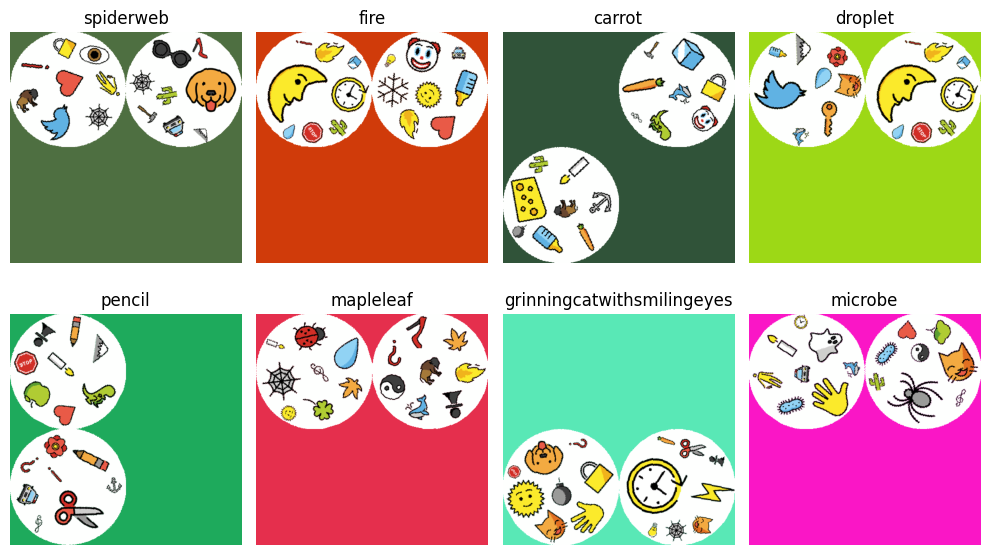

In [39]:
emoji_labels_csv = os.path.join(data_dir_path, 'classic-dobble-224-px', 'emoji_labels.csv')
labels_dict = create_labels_dict(emoji_labels_csv)

images, labels = next(iter(test_loader))

# Convert PyTorch tensor to NumPy array and swap color channel to the back
images_np = images.numpy()
images_np = np.transpose(images_np, (0, 2, 3, 1))  # (B, H, W, C)

# Create a 4x2 subplot and flatten the subplot array for easier indexing
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flatten()

for i, (image, label) in enumerate(zip(images_np, labels)):
    # Extract individual color channels
    r, g, b = image.transpose((2, 0, 1))

    # Undo the normalization
    r = r * std[0].item() + mean[0].item()
    g = g * std[1].item() + mean[1].item()
    b = b * std[2].item() + mean[2].item()

    # Recombine color channels
    image = np.dstack((r, g, b))

    # NOTE: By normalizing and then undoing the normalization, we have introduced some computational inaccuracy.
    # To make sure that the values are within the valid range, we clip the values to the unit interval.
    image = np.clip(image, 0, 1)

    ax = axs[i]
    ax.imshow(image)
    ax.set_title(labels_dict[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()


<a id='neural-network-dobble-net'></a>

### 3.2 *DobbleNet*
<font color=red>**TO-DO:**</font> Add text!

In [40]:
# NOTE: We're not using 'nn.Softmax()' on our output because we want to use 'nn.CrossEntropyLoss()' as loss function!
class DobbleNet(nn.Module):
    def __init__(self, num_emojis_per_card: int) -> None:
        """
        Params:
            num_emojis_per_card (int): The number of emojis on each card (determines number of distinct emojis [i.e., classes]).
        """
        super().__init__()

        order = num_emojis_per_card - 1
        num_classes = order**2 + order + 1

        self.features = nn.Sequential(
            # starting spatial resolution: H x W
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # spatial resolution: H/2 x W/2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # spatial resolution: H/4 x W/4
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)  # spatial resolution: H/8 x W/8
        )

        self.avgpool = nn.AdaptiveAvgPool2d((14, 14))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(14 * 14 * 64, num_classes)  # H * W * nKernels
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        
        return x


Next, we instantiate an instance of *DobbleNet* and we move the model to the GPU, if available.

In [41]:
# NOTE: 'num_emojis_per_card' is still defined from when we generated our dataset
model = DobbleNet(num_emojis_per_card=num_emojis_per_card)
model = model.to(device)
print(model)

DobbleNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(14, 14))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1)

<a id='neural-network-training-testing-routines'></a>

### 3.3 Training & testing routines

<a id='neural-network-loss'></a>

#### 3.3.1 Loss function
Since our ground-truth is a finite set of categories (i.e., the distinct emojis in a deck of *Dobble* cards), we will use `nn.CrossEntropyLoss` as our loss function.

In [42]:
# We define our loss function and move it to the GPU, if available
criterion = nn.CrossEntropyLoss().to(device)

<a id='neural-network-optimizer'></a>

#### 3.3.2 Optimizer
For now, we'll simply use **SGD** as our optimizer.

In [43]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4

optimizer = torch.optim.SGD(
    params=model.parameters(), lr=learning_rate,
    momentum=momentum, weight_decay=weight_decay
)

<a id='neural-network-accuracy'></a>

#### 3.3.3 Computing accuracy
`accuracy` is a little helper function that gives us slightly more flexibility when computing the accuracy of our model compared to just calculating the fraction of samples the model predicted correctly.

In [44]:
def accuracy(output, target, topk=(1,)):
    """
    Calculate the accuracy of a model's output predictions.

    Params:
        output (torch.Tensor): Model's output tensor.
        target (torch.Tensor): Target tensor containing the ground truth labels.
        topk (tuple): Tuple of integers representing the top-k values to consider for accuracy calculation.
            Defaults to (1,).

    Returns:
        list[torch.Tensor]: A list of torch.Tensor objects representing accuracy values for each top-k value specified.

    Note:
        - The top-k accuracy considers whether the correct label is among the top-k predicted labels.

    Example:
        >>> output = torch.tensor([[0.2, 0.3, 0.5], [0.7, 0.1, 0.2]])
        >>> target = torch.tensor([1, 1])
        >>> accuracy(output, target, topk=(1, 2, 3))
        [tensor([0.]), tensor([50.]), tensor([100.])]
    """
    with torch.no_grad():
        maxk = max(topk)  # max 'topk' value
        batch_size = target.size(0)  # number of labels (= number of samples in the batch)

        # Compute indices of top k values for each prediction
        _, pred = output.topk(maxk, 1, largest=True, sorted=True)
        pred = pred.t()

        # Check whether predictions match target (i.e., ground truth labels)
        # NOTE: The '-1' in target.view(1, -1) implies that the size of this dimension is inferred from other dimensions
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


<a id='neural-network-training'></a>

#### 3.3.4 Training the model
The function `train_one_epoch` is used to train a model on a full training set exactly once. It returns the average loss and the average accuracy across the full epoch.

In [45]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # set model to training mode

    running_loss = 0.0
    running_acc = 0.0

    total_samples = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        samples = len(labels)
        
        optimizer.zero_grad()  # zero the gradients

        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights

        total_samples += samples
        running_loss += loss.item() * samples  # accumulate loss over epoch
        acc = accuracy(outputs, labels)  # compute accuracy
        running_acc += acc[0].item() * samples  # accumulate accuracy over epoch

    train_loss = running_loss / total_samples
    train_acc = running_acc / total_samples

    return train_loss, train_acc


The function `validate` can be used to validate a model after an epoch of training. Just like the `train_one_epoch` function, it returns the average loss and the average accuracy across the entire validation set.

In [46]:
def validate(model, val_loader, criterion, device):
    model.eval()  # set model to evaluation mode

    running_loss = 0.0
    running_acc = 0.0

    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            samples = len(labels)

            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss

            total_samples += samples
            running_loss += loss.item() * samples  # accumulate loss over epoch
            acc = accuracy(outputs, labels)  # compute accuracy
            running_acc += acc[0].item() * samples  # accumulate accuracy over epoch

    val_loss = running_loss / total_samples
    val_acc = running_acc / total_samples

    return val_loss, val_acc


Finally, we combine both functions (i.e., `train_one_epoch` and `validate`) into a single function that trains a model in multiple epochs on a given training set and validates it after every single epoch using a specified validation set.

In [47]:
def train(model, train_loader, val_loader, criterion, optimizer, device, init_epoch, num_epochs, print_freq=None):
    # If no 'print_freq' is specified, we print every 10 % of total epochs
    if print_freq is None:
        print_freq = num_epochs // 10

    # Set up dictionaries
    train_logs = {'loss': [], 'acc': []}
    val_logs = {'loss': [], 'acc': []}

    for epoch in range(init_epoch, init_epoch + num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_logs['loss'].append(train_loss)
        train_logs['acc'].append(train_acc)
        val_logs['loss'].append(val_loss)
        val_logs['acc'].append(val_acc)

        if (epoch + 1) % print_freq == 0:
            print('Epoch [%d/%d]    Train    Loss=%.4f    Acc=%0.2f        Val    Loss=%.4f    Acc=%0.2f' % 
                  (
                      epoch + 1,  # epoch number
                      init_epoch + num_epochs, # total number of epochs
                      train_loss,  # loss (training)
                      train_acc,  # accuracy (training)
                      val_loss,  # loss (validation)
                      val_acc  # accuracy (validation)
                  ))

    return train_logs, val_logs


<a id='neural-network-overfitting-single-batch'></a>

### 3.4 Overfitting a single batch
As a sanity check to rule out any major bugs, we check if our model is able to overfit a single batch of just 8 images. To do so, we first write a little helper function that does just that.

In [48]:
def overfit_single_batch(model, criterion, optimizer, device, inputs, labels, num_epochs, print_freq=None):
    # If no 'print_freq' is specified, we print every 10 % of total epochs
    if print_freq is None:
        print_freq = num_epochs // 10

    overfit_logs = {'loss': [], 'acc': []}
        
    model.train()  # set model to training mode

    inputs = inputs.to(device)
    labels = labels.to(device)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # zero the gradients

        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # compute loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights

        acc = accuracy(outputs, labels)  # compute accuracy

        overfit_logs['loss'].append(loss.item())
        overfit_logs['acc'].append(acc[0].item())

        if (epoch + 1) % print_freq == 0:
            print('Epoch [%d/%d]    Loss=%.4f    Acc=%0.2f' %
                  (
                      epoch + 1,  # epoch number
                      num_epochs,  # total number of epochs
                      loss.item(),  # loss
                      acc[0].item()  # accuracy
                  ))

    return overfit_logs


We now extract the first batch of our `train_loader` and try to overfit our model on that batch.

In [49]:
inputs, labels = next(iter(train_loader))
num_epochs = 200
print_freq = 20

overfit_logs = overfit_single_batch(model, criterion, optimizer, device, inputs, labels, num_epochs, print_freq)

Epoch [20/200]    Loss=0.0000    Acc=100.00
Epoch [40/200]    Loss=0.0000    Acc=100.00
Epoch [60/200]    Loss=0.0000    Acc=100.00
Epoch [80/200]    Loss=0.0000    Acc=100.00
Epoch [100/200]    Loss=0.0000    Acc=100.00
Epoch [120/200]    Loss=0.0000    Acc=100.00
Epoch [140/200]    Loss=0.0000    Acc=100.00
Epoch [160/200]    Loss=0.0000    Acc=100.00
Epoch [180/200]    Loss=0.0000    Acc=100.00
Epoch [200/200]    Loss=0.0000    Acc=100.00


Let's plot the results of our overfitting attempt!

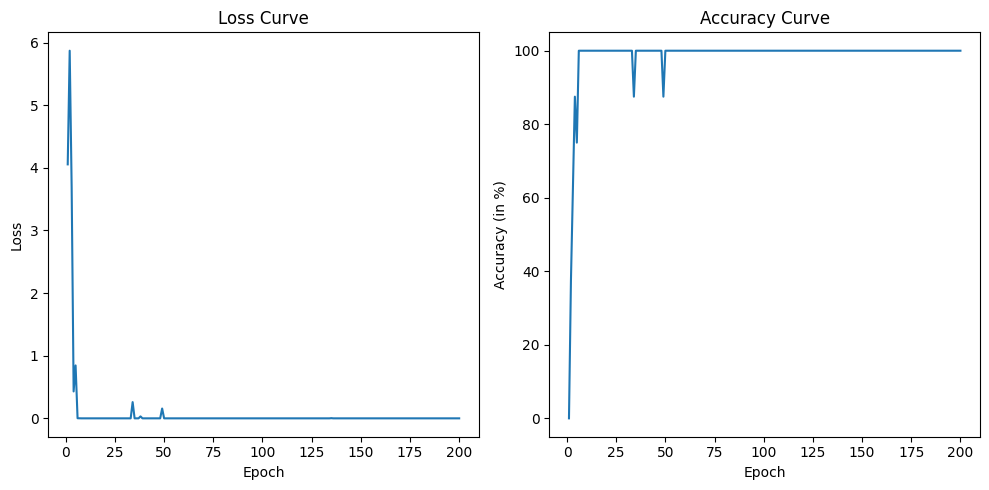

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    axs[i].plot(range(1, num_epochs + 1), overfit_logs['loss'] if i == 0 else overfit_logs['acc'])
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss' if i == 0 else 'Accuracy (in %)')
    axs[i].set_title('Loss Curve' if i == 0 else 'Accuracy Curve')

plt.tight_layout()
plt.show()


<a id='neural-network-training-dobblenet'></a>

### 3.5 Training *DobbleNet*

Since overfitting a single batch worked perfectly fine, we now start to train our model using our training and valdiation sets.

In [51]:
# Reset the model's weights by simply reinitializing it
model = DobbleNet(num_emojis_per_card=num_emojis_per_card)
model = model.to(device)

# Let's train the model for 100 epochs and see where that gets us
init_epoch = 0
num_epochs = 100
print_freq = 10

start_time = time.time()

train_logs, val_logs = train(model, train_loader, val_loader, criterion, optimizer, device, init_epoch, num_epochs, print_freq)

end_time = time.time()
total_time = end_time - start_time

# Convert 'total_time' to minutes and seconds
minutes = int(total_time // 60)
seconds = int(total_time % 60)

print(f"Training time: {minutes} minutes {seconds} seconds")

Epoch [10/100]    Train    Loss=4.4060    Acc=1.75        Val    Loss=4.2406    Acc=1.67


KeyboardInterrupt: 